In [1]:
import xarray as xr 
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import os 
import copy
from scipy import signal

import matplotlib.pyplot as plt
import matplotlib as mpl
#import collections
import matplotlib.ticker as mticker
from matplotlib import ticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.crs as ccrs
import cartopy as cart
import cartopy.mpl.ticker as cticker
import cartopy.feature as cfeature
from matplotlib.colors import ListedColormap
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cmocean
import scipy as sp
import warnings
warnings.filterwarnings("ignore")
import os
import eofs.standard as Eof_st
from eofs.multivariate.standard import MultivariateEof

from scipy.signal import butter, lfilter
from scipy.signal import convolve

import importlib


## import dask

In [17]:
print('...setting up dask client...')
if 'client' in locals():
    client.shutdown()
    print('...shutdown client...')
else:
    print('client does not exist yet')

...setting up dask client...
...shutdown client...


In [18]:
rm dask-worker*

In [4]:
# ### ++++++ dask NCAR client: 
from distributed import Client
from dask_jobqueue import PBSCluster
project_num = 'P03010039' #what project key do you have? 

cluster = PBSCluster(account=project_num,walltime='12:00:00',cores=1, memory='40GB',shared_temp_directory='/glade/derecho/scratch/wchapman/tmp',queue='casper')
cluster.scale(jobs=40)
client = Client(cluster)

## Load Data

In [13]:
# dir_in = '/glade/derecho/scratch/wchapman/ADF/f.e.FTORCHmjo_fullCNN_DT/ts/climo/'
# dir_in_ts = '/glade/derecho/scratch/wchapman/ADF/f.e.FTORCHmjo_fullCNN_DT/ts/'

# filu = 'f.e.FTORCHmjo_fullCNN_DT.cam.h1.U.anomalies.1979010100000-1990123100000.nc'
# var_name_u = 'U'

# phases_in = 'f.e.FTORCHmjo_fullCNN_DT.cam.h1.MJO_EOFS_FLUT_U200_U850.nc'

###########################################################################
######################### Templates #######################################
###########################################################################

# dir_in = '/glade/derecho/scratch/wchapman/ADF/f.e.FTORCHmjo_CNTRLmjo_DT/ts/climo/'
# dir_in_ts = '/glade/derecho/scratch/wchapman/ADF/f.e.FTORCHmjo_CNTRLmjo_DT/ts/'

# filu = 'f.e.FTORCHmjo_CNTRLmjo_DT.cam.h1.U.anomalies.1979010100000-1990122200000.nc'
# var_name_u = 'U'

# phases_in = 'f.e.FTORCHmjo_CNTRLmjo_DT.cam.h1.MJO_EOFS_FLUT_U200_U850.nc'

###########################################################################
######################### Templates #######################################
###########################################################################


# dir_in = '/glade/derecho/scratch/wchapman/ADF/f.e.FTORCHmjo_MEANmjo_DT/ts/climo/'
# dir_in_ts = '/glade/derecho/scratch/wchapman/ADF/f.e.FTORCHmjo_MEANmjo_DT/ts/'

# filu = 'f.e.FTORCHmjo_MEANmjo_DT.cam.h1.U.anomalies.1979010100000-1990122200000.nc'
# var_name_u = 'U'

# phases_in = 'f.e.FTORCHmjo_MEANmjo_DT.cam.h1.MJO_EOFS_FLUT_U200_U850.nc'

##########################################################################
######################### Templates #######################################
###########################################################################


dir_in = '/glade/derecho/scratch/wchapman/ADF/f.e.FTORCHmjo_CNNmjo_DT/ts/climo/'
dir_in_ts = '/glade/derecho/scratch/wchapman/ADF/f.e.FTORCHmjo_CNNmjo_DT/ts/'

filu = 'f.e.FTORCHmjo_CNNmjo_DT.cam.h1.U.anomalies.1979010100000-1990122200000.nc'
var_name_u = 'U'

phases_in = 'f.e.FTORCHmjo_CNNmjo_DT.cam.h1.MJO_EOFS_FLUT_U200_U850.nc'




dir_out = f'{dir_in}/mjo_diag/'
# Check if the directory exists
if not os.path.exists(dir_out):
    # Create the directory
    os.makedirs(dir_out)
    print(f"Directory {dir_out} created.")


save_Fig_out = f'{dir_out}/{filu.split("h1")[0]}h1.MJO_Composite_maritime_{var_name_u}.png'
print(f'saving figure to {save_Fig_out}')

saving figure to /glade/derecho/scratch/wchapman/ADF/f.e.FTORCHmjo_CNNmjo_DT/ts/climo//mjo_diag//f.e.FTORCHmjo_CNNmjo_DT.cam.h1.MJO_Composite_maritime_U.png


## Data in

In [14]:
# u200: 
file_path_u = os.path.join(dir_in, filu)  # Join the directory and file name
DS_u = xr.open_dataset(file_path_u)

file_path_phases = os.path.join(dir_out, phases_in)  # Join the directory and file name
DS_phases = xr.open_dataset(file_path_phases)

#create cosine latitude weighting: 
weights = np.cos(np.deg2rad(DS_u.lat))

## Select Winter

In [15]:
%%time
NDFJMA_u = DS_u.where((DS_u['time.month'] >= 11) | (DS_u['time.month'] <= 5), drop=True)
NDFJMA_phases = DS_phases.where((DS_phases['time.month'] >= 11) | (DS_phases['time.month'] <= 5), drop=True)

CPU times: user 20.5 s, sys: 3min 34s, total: 3min 54s
Wall time: 4min 47s


## Composite by Region

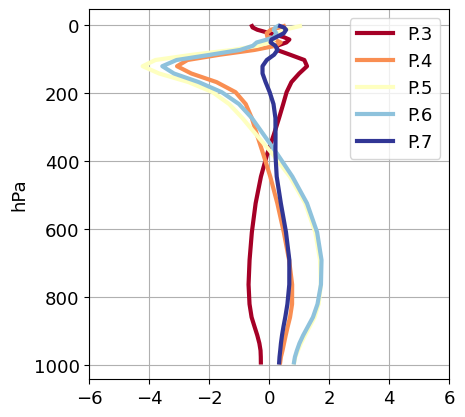

In [16]:
fig = plt.figure(figsize=(20, 10))  # Adjusted figure size for 8 panels
colors = plt.cm.RdYlBu(np.linspace(0,1,5))
ax10 = fig.add_axes([0.94,.51, 0.18, 0.37]) 
for phs in range(3,8):
    inds = np.where(NDFJMA_phases['RMMphase_obs']==phs)[0]
    Phase_Incs_mjo = (NDFJMA_u.isel(time=inds))
    ax10.plot(((Phase_Incs_mjo.sel(lat=slice(-15,15),lon=slice(90,180))).mean(['time','lat','lon'])[var_name_u]).rolling(lev=3, center=True,min_periods=1).mean(),
             Phase_Incs_mjo['lev'],label=f'P.{phs}',linewidth=3, color=colors[phs-3])

ax10.set_xlim([-6,6])
ax10.set_ylabel('hPa',fontsize=13)
ax10.invert_yaxis()
ax10.legend(fontsize=13)
ax10.tick_params(labelsize=13) 
ax10.grid(True)
bbox_props = dict(fc="white", ec="teal", lw=2)
plt.savefig(save_Fig_out,bbox_inches='tight',dpi=400)
plt.show()

saving figure to /glade/derecho/scratch/wchapman/ADF/f.e.FTORCHmjo_CNNmjo_DT/ts/climo//mjo_diag//f.e.FTORCHmjo_CNNmjo_DT.cam.h1.MJO_Composite_maritime_V.png


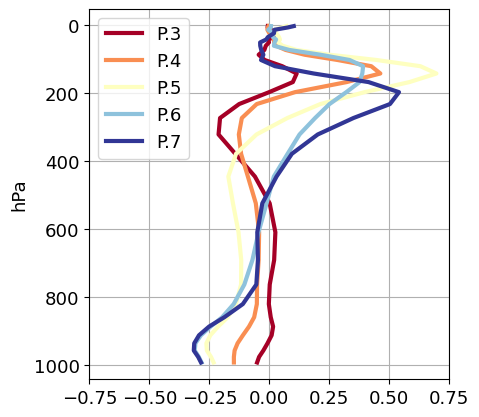

CPU times: user 19.6 s, sys: 30.1 s, total: 49.8 s
Wall time: 1min 4s


In [10]:
%%time
# dir_in = '/glade/derecho/scratch/wchapman/ADF/f.e.FTORCHmjo_fullCNN_DT/ts/climo/'
# dir_in_ts = '/glade/derecho/scratch/wchapman/ADF/f.e.FTORCHmjo_fullCNN_DT/ts/'

# filu = 'f.e.FTORCHmjo_fullCNN_DT.cam.h1.V.anomalies.1979010100000-1990123100000.nc'
# var_name_u = 'V'

# phases_in = 'f.e.FTORCHmjo_fullCNN_DT.cam.h1.MJO_EOFS_FLUT_U200_U850.nc'

###########################################################################
######################### Templates #######################################
###########################################################################

# dir_in = '/glade/derecho/scratch/wchapman/ADF/f.e.FTORCHmjo_CNTRLmjo_DT/ts/climo/'
# dir_in_ts = '/glade/derecho/scratch/wchapman/ADF/f.e.FTORCHmjo_CNTRLmjo_DT/ts/'

# filu = 'f.e.FTORCHmjo_CNTRLmjo_DT.cam.h1.V.anomalies.1979010100000-1990122200000.nc'
# var_name_u = 'V'

# phases_in = 'f.e.FTORCHmjo_CNTRLmjo_DT.cam.h1.MJO_EOFS_FLUT_U200_U850.nc'

###########################################################################
######################### Templates #######################################
###########################################################################

# dir_in = '/glade/derecho/scratch/wchapman/ADF/f.e.FTORCHmjo_MEANmjo_DT/ts/climo/'
# dir_in_ts = '/glade/derecho/scratch/wchapman/ADF/f.e.FTORCHmjo_MEANmjo_DT/ts/'

# filu = 'f.e.FTORCHmjo_MEANmjo_DT.cam.h1.V.anomalies.1979010100000-1990122200000.nc'
# var_name_u = 'V'

# phases_in = 'f.e.FTORCHmjo_MEANmjo_DT.cam.h1.MJO_EOFS_FLUT_U200_U850.nc'

###########################################################################
######################### Templates #######################################
###########################################################################


dir_in = '/glade/derecho/scratch/wchapman/ADF/f.e.FTORCHmjo_CNNmjo_DT/ts/climo/'
dir_in_ts = '/glade/derecho/scratch/wchapman/ADF/f.e.FTORCHmjo_CNNmjo_DT/ts/'

filu = 'f.e.FTORCHmjo_CNNmjo_DT.cam.h1.V.anomalies.1979010100000-1990122200000.nc'
var_name_u = 'V'

phases_in = 'f.e.FTORCHmjo_CNNmjo_DT.cam.h1.MJO_EOFS_FLUT_U200_U850.nc'


dir_out = f'{dir_in}/mjo_diag/'
# Check if the directory exists
if not os.path.exists(dir_out):
    # Create the directory
    os.makedirs(dir_out)
    print(f"Directory {dir_out} created.")


save_Fig_out = f'{dir_out}/{filu.split("h1")[0]}h1.MJO_Composite_maritime_{var_name_u}.png'
print(f'saving figure to {save_Fig_out}')

# u200: 
file_path_u = os.path.join(dir_in, filu)  # Join the directory and file name
DS_u = xr.open_dataset(file_path_u)

file_path_phases = os.path.join(dir_out, phases_in)  # Join the directory and file name
DS_phases = xr.open_dataset(file_path_phases)

#create cosine latitude weighting: 
weights = np.cos(np.deg2rad(DS_u.lat))

NDFJMA_u = DS_u.where((DS_u['time.month'] >= 11) | (DS_u['time.month'] <= 5), drop=True)
NDFJMA_phases = DS_phases.where((DS_phases['time.month'] >= 11) | (DS_phases['time.month'] <= 5), drop=True)

fig = plt.figure(figsize=(20, 10))  # Adjusted figure size for 8 panels
colors = plt.cm.RdYlBu(np.linspace(0,1,5))
ax10 = fig.add_axes([0.94,.51, 0.18, 0.37]) 
for phs in range(3,8):
    inds = np.where(NDFJMA_phases['RMMphase_obs']==phs)[0]
    Phase_Incs_mjo = (NDFJMA_u.isel(time=inds))
    ax10.plot(((Phase_Incs_mjo.sel(lat=slice(-15,15),lon=slice(90,180))).mean(['time','lat','lon'])[var_name_u]).rolling(lev=3, center=True,min_periods=1).mean(),
             Phase_Incs_mjo['lev'],label=f'P.{phs}',linewidth=3, color=colors[phs-3])

ax10.set_xlim([-.75,.75])
ax10.set_ylabel('hPa',fontsize=13)
ax10.invert_yaxis()
ax10.legend(fontsize=13)
ax10.tick_params(labelsize=13) 
ax10.grid(True)
bbox_props = dict(fc="white", ec="teal", lw=2)
plt.savefig(save_Fig_out,bbox_inches='tight',dpi=400)
plt.show()

saving figure to /glade/derecho/scratch/wchapman/ADF/f.e.FTORCHmjo_CNNmjo_DT/ts/climo//mjo_diag//f.e.FTORCHmjo_CNNmjo_DT.cam.h1.MJO_Composite_maritime_T.png


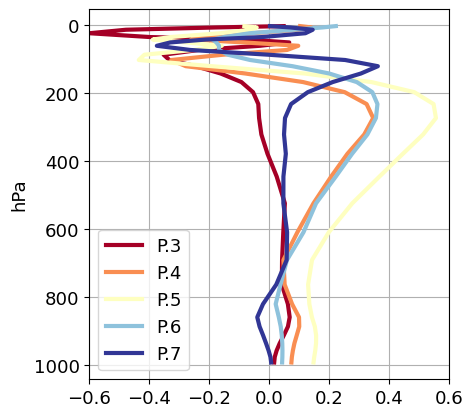

CPU times: user 26.7 s, sys: 3min 7s, total: 3min 34s
Wall time: 3min 55s


In [11]:
%%time
# dir_in = '/glade/derecho/scratch/wchapman/ADF/f.e.FTORCHmjo_fullCNN_DT/ts/climo/'
# dir_in_ts = '/glade/derecho/scratch/wchapman/ADF/f.e.FTORCHmjo_fullCNN_DT/ts/'

# filu = 'f.e.FTORCHmjo_fullCNN_DT.cam.h1.T.anomalies.1979010100000-1990123100000.nc'
# var_name_u = 'T'

# phases_in = 'f.e.FTORCHmjo_fullCNN_DT.cam.h1.MJO_EOFS_FLUT_U200_U850.nc'

###########################################################################
######################### Templates #######################################
###########################################################################

# dir_in = '/glade/derecho/scratch/wchapman/ADF/f.e.FTORCHmjo_CNTRLmjo_DT/ts/climo/'
# dir_in_ts = '/glade/derecho/scratch/wchapman/ADF/f.e.FTORCHmjo_CNTRLmjo_DT/ts/'

# filu = 'f.e.FTORCHmjo_CNTRLmjo_DT.cam.h1.T.anomalies.1979010100000-1990122200000.nc'
# var_name_u = 'T'

# phases_in = 'f.e.FTORCHmjo_CNTRLmjo_DT.cam.h1.MJO_EOFS_FLUT_U200_U850.nc'

###########################################################################
######################### Templates #######################################
###########################################################################

# dir_in = '/glade/derecho/scratch/wchapman/ADF/f.e.FTORCHmjo_MEANmjo_DT/ts/climo/'
# dir_in_ts = '/glade/derecho/scratch/wchapman/ADF/f.e.FTORCHmjo_MEANmjo_DT/ts/'

# filu = 'f.e.FTORCHmjo_MEANmjo_DT.cam.h1.T.anomalies.1979010100000-1990122200000.nc'
# var_name_u = 'T'

# phases_in = 'f.e.FTORCHmjo_MEANmjo_DT.cam.h1.MJO_EOFS_FLUT_U200_U850.nc'

###########################################################################
######################### Templates #######################################
###########################################################################

dir_in = '/glade/derecho/scratch/wchapman/ADF/f.e.FTORCHmjo_CNNmjo_DT/ts/climo/'
dir_in_ts = '/glade/derecho/scratch/wchapman/ADF/f.e.FTORCHmjo_CNNmjo_DT/ts/'

filu = 'f.e.FTORCHmjo_CNNmjo_DT.cam.h1.T.anomalies.1979010100000-1990122200000.nc'
var_name_u = 'T'

phases_in = 'f.e.FTORCHmjo_CNNmjo_DT.cam.h1.MJO_EOFS_FLUT_U200_U850.nc'


dir_out = f'{dir_in}/mjo_diag/'
# Check if the directory exists
if not os.path.exists(dir_out):
    # Create the directory
    os.makedirs(dir_out)
    print(f"Directory {dir_out} created.")


save_Fig_out = f'{dir_out}/{filu.split("h1")[0]}h1.MJO_Composite_maritime_{var_name_u}.png'
print(f'saving figure to {save_Fig_out}')

# u200: 
file_path_u = os.path.join(dir_in, filu)  # Join the directory and file name
DS_u = xr.open_dataset(file_path_u)

file_path_phases = os.path.join(dir_out, phases_in)  # Join the directory and file name
DS_phases = xr.open_dataset(file_path_phases)

#create cosine latitude weighting: 
weights = np.cos(np.deg2rad(DS_u.lat))

NDFJMA_u = DS_u.where((DS_u['time.month'] >= 11) | (DS_u['time.month'] <= 5), drop=True)
NDFJMA_phases = DS_phases.where((DS_phases['time.month'] >= 11) | (DS_phases['time.month'] <= 5), drop=True)

fig = plt.figure(figsize=(20, 10))  # Adjusted figure size for 8 panels
colors = plt.cm.RdYlBu(np.linspace(0,1,5))
ax10 = fig.add_axes([0.94,.51, 0.18, 0.37]) 
for phs in range(3,8):
    inds = np.where(NDFJMA_phases['RMMphase_obs']==phs)[0]
    Phase_Incs_mjo = (NDFJMA_u.isel(time=inds))
    ax10.plot(((Phase_Incs_mjo.sel(lat=slice(-15,15),lon=slice(90,180))).mean(['time','lat','lon'])[var_name_u]).rolling(lev=3, center=True,min_periods=1).mean(),
             Phase_Incs_mjo['lev'],label=f'P.{phs}',linewidth=3, color=colors[phs-3])

ax10.set_xlim([-.6,.6])
ax10.set_ylabel('hPa',fontsize=13)
ax10.invert_yaxis()
ax10.legend(fontsize=13)
ax10.tick_params(labelsize=13) 
ax10.grid(True)
bbox_props = dict(fc="white", ec="teal", lw=2)
plt.savefig(save_Fig_out,bbox_inches='tight',dpi=400)
plt.show()

saving figure to /glade/derecho/scratch/wchapman/ADF/f.e.FTORCHmjo_CNNmjo_DT/ts/climo//mjo_diag//f.e.FTORCHmjo_CNNmjo_DT.cam.h1.MJO_Composite_maritime_Q.png


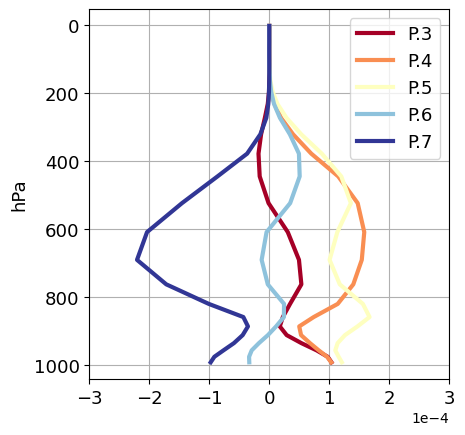

CPU times: user 25.5 s, sys: 2min 28s, total: 2min 53s
Wall time: 3min 32s


In [12]:
%%time
# dir_in = '/glade/derecho/scratch/wchapman/ADF/f.e.FTORCHmjo_fullCNN_DT/ts/climo/'
# dir_in_ts = '/glade/derecho/scratch/wchapman/ADF/f.e.FTORCHmjo_fullCNN_DT/ts/'

# filu = 'f.e.FTORCHmjo_fullCNN_DT.cam.h1.Q.anomalies.1979010100000-1990123100000.nc'
# var_name_u = 'Q'

# phases_in = 'f.e.FTORCHmjo_fullCNN_DT.cam.h1.MJO_EOFS_FLUT_U200_U850.nc'

###########################################################################
######################### Templates #######################################
###########################################################################

# dir_in = '/glade/derecho/scratch/wchapman/ADF/f.e.FTORCHmjo_CNTRLmjo_DT/ts/climo/'
# dir_in_ts = '/glade/derecho/scratch/wchapman/ADF/f.e.FTORCHmjo_CNTRLmjo_DT/ts/'

# filu = 'f.e.FTORCHmjo_CNTRLmjo_DT.cam.h1.Q.anomalies.1979010100000-1990122200000.nc'
# var_name_u = 'Q'

# phases_in = 'f.e.FTORCHmjo_CNTRLmjo_DT.cam.h1.MJO_EOFS_FLUT_U200_U850.nc'

###########################################################################
######################### Templates #######################################
###########################################################################

# dir_in = '/glade/derecho/scratch/wchapman/ADF/f.e.FTORCHmjo_MEANmjo_DT/ts/climo/'
# dir_in_ts = '/glade/derecho/scratch/wchapman/ADF/f.e.FTORCHmjo_MEANmjo_DT/ts/'

# filu = 'f.e.FTORCHmjo_MEANmjo_DT.cam.h1.Q.anomalies.1979010100000-1990122200000.nc'
# var_name_u = 'Q'

# phases_in = 'f.e.FTORCHmjo_MEANmjo_DT.cam.h1.MJO_EOFS_FLUT_U200_U850.nc'

###########################################################################
######################### Templates #######################################
###########################################################################

dir_in = '/glade/derecho/scratch/wchapman/ADF/f.e.FTORCHmjo_CNNmjo_DT/ts/climo/'
dir_in_ts = '/glade/derecho/scratch/wchapman/ADF/f.e.FTORCHmjo_CNNmjo_DT/ts/'

filu = 'f.e.FTORCHmjo_CNNmjo_DT.cam.h1.Q.anomalies.1979010100000-1990122200000.nc'
var_name_u = 'Q'

phases_in = 'f.e.FTORCHmjo_CNNmjo_DT.cam.h1.MJO_EOFS_FLUT_U200_U850.nc'

dir_out = f'{dir_in}/mjo_diag/'
# Check if the directory exists
if not os.path.exists(dir_out):
    # Create the directory
    os.makedirs(dir_out)
    print(f"Directory {dir_out} created.")


save_Fig_out = f'{dir_out}/{filu.split("h1")[0]}h1.MJO_Composite_maritime_{var_name_u}.png'
print(f'saving figure to {save_Fig_out}')

# u200: 
file_path_u = os.path.join(dir_in, filu)  # Join the directory and file name
DS_u = xr.open_dataset(file_path_u)

file_path_phases = os.path.join(dir_out, phases_in)  # Join the directory and file name
DS_phases = xr.open_dataset(file_path_phases)

#create cosine latitude weighting: 
weights = np.cos(np.deg2rad(DS_u.lat))

NDFJMA_u = DS_u.where((DS_u['time.month'] >= 11) | (DS_u['time.month'] <= 5), drop=True)
NDFJMA_phases = DS_phases.where((DS_phases['time.month'] >= 11) | (DS_phases['time.month'] <= 5), drop=True)

fig = plt.figure(figsize=(20, 10))  # Adjusted figure size for 8 panels
colors = plt.cm.RdYlBu(np.linspace(0,1,5))
ax10 = fig.add_axes([0.94,.51, 0.18, 0.37]) 
for phs in range(3,8):
    inds = np.where(NDFJMA_phases['RMMphase_obs']==phs)[0]
    Phase_Incs_mjo = (NDFJMA_u.isel(time=inds))
    ax10.plot(((Phase_Incs_mjo.sel(lat=slice(-15,15),lon=slice(90,180))).mean(['time','lat','lon'])[var_name_u]).rolling(lev=3, center=True,min_periods=1).mean(),
             Phase_Incs_mjo['lev'],label=f'P.{phs}',linewidth=3, color=colors[phs-3])

ax10.set_xlim([-.3*1e-3,.3*1e-3])
ax10.set_ylabel('hPa',fontsize=13)
ax10.invert_yaxis()
ax10.legend(fontsize=13)
ax10.tick_params(labelsize=13) 
ax10.grid(True)
ax10.ticklabel_format(style='sci', axis='x',scilimits=(1,4))
bbox_props = dict(fc="white", ec="teal", lw=2)
plt.savefig(save_Fig_out,bbox_inches='tight',dpi=400)
plt.show()